# An impact of adversarial data ovarsampling within imbalanced datasets on training image CNNs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import Helper_functions as hf
import json
import copy
import imblearn
import sklearn

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.05)
sss.get_n_splits(train_images, train_labels)
(train_indices, validation_indices) = next(sss.split(train_images, train_labels))
(validation_images, validation_labels) = (train_images[validation_indices], train_labels[validation_indices])
(train_images, train_labels) = (train_images[train_indices], train_labels[train_indices])

60k 28x28 train images with labels  
10k 28x28 validation images with labels

##  baseline model with balanced data

In [3]:
train_images_expanded = np.expand_dims(train_images, axis = 3)
validation_images_expanded = np.expand_dims(validation_images, axis = 3)
test_images_expanded = np.expand_dims(test_images, axis = 3)
with tf.device('CPU:0'):
    train_images_tf = tf.cast(train_images_expanded, dtype = tf.float32) / 255.0
    validation_images_tf = tf.cast(validation_images_expanded, dtype = tf.float32) / 255.0
    test_images_tf = tf.cast(test_images_expanded, dtype = tf.float32) / 255.0

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [5]:
def model_run(model_name, epochs, ti, tl, vi, vl, optimizer, loss, metrics, callbacks):
    model_name.add(tf.keras.layers.Conv2D(28, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.Flatten())
    model_name.add(tf.keras.layers.Dense(56, activation = 'relu'))
    model_name.add(tf.keras.layers.Dense(10))
    model_name.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    with tf.device('GPU:0'):
        history = model_name.fit(
        ti, tl,
        epochs = epochs,
        validation_data = (vi, vl))
        model_name.summary()
    return history
def write_to_json(dictionary, gmean, fscore, filename):
    dictionary = copy.deepcopy(dictionary)
    for key in dictionary.keys():
        dictionary[key] = str(dictionary[key][-1])
    dictionary['gmean'] = str(gmean)
    dictionary['fscore'] = str(fscore)
    with open(filename, 'w') as f:
        json.dump(dictionary, f)

In [6]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, train_images_tf, train_labels, validation_images_tf, validation_labels, 
          optimizer, loss, metrics, callbacks)
baseline.save('checkpoints/baseline.hdf5')

Train on 57000 samples, validate on 3000 samples
Epoch 1/20
57000/57000 [==============================] - 8s 148us/sample - loss: 0.3624 - acc: 0.8992 - val_loss: 0.1388 - val_acc: 0.9590
Epoch 2/20
57000/57000 [==============================] - 7s 117us/sample - loss: 0.1041 - acc: 0.9694 - val_loss: 0.0891 - val_acc: 0.9773
Epoch 3/20
57000/57000 [==============================] - 7s 117us/sample - loss: 0.0739 - acc: 0.9771 - val_loss: 0.0801 - val_acc: 0.9767
Epoch 4/20
57000/57000 [==============================] - 7s 117us/sample - loss: 0.0582 - acc: 0.9819 - val_loss: 0.0554 - val_acc: 0.9863
Epoch 5/20
57000/57000 [==============================] - 7s 117us/sample - loss: 0.0472 - acc: 0.9854 - val_loss: 0.0544 - val_acc: 0.9857
Epoch 6/20
57000/57000 [==============================] - 7s 117us/sample - loss: 0.0399 - acc: 0.9878 - val_loss: 0.0590 - val_acc: 0.9847
Epoch 7/20
57000/57000 [==============================] - 7s 117us/sample - loss: 0.0352 - acc: 0.9891 - val_lo

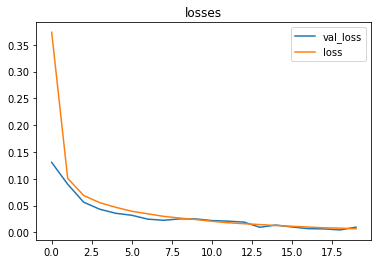

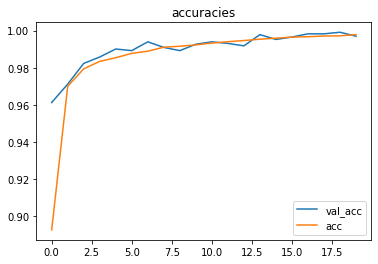

In [19]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [21]:
with tf.device('CPU:0'):
    baseline_test_preds = tf.argmax(baseline(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    baseline_fscore = sklearn.metrics.f1_score(test_labels, baseline_test_preds, average = 'macro')
print(f'gmean: {baseline_gmean} \nfscore: {baseline_fscore}')

gmean: 0.8875922536017117 
fscore: 0.9092607957315668


In [9]:
write_to_json(history.history, baseline_gmean, baseline_fscore, 'checkpoints/balanced/metrics_balanced.json')

## make imbalanced set $\mu=0.1 \rho=100$

{0: 5150, 1: 5, 2: 5150, 3: 5150, 4: 5150, 5: 5150, 6: 5150, 7: 5150, 8: 5150, 9: 5150}


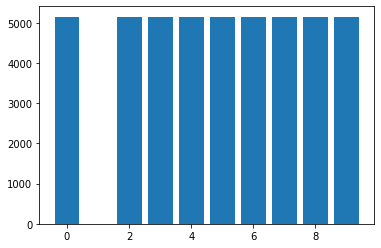

mu = 0.1, rho = 1030.0


In [6]:
with tf.device('CPU:0'):
    (imb_train_images, imb_train_labels) = hf.Imbalance.change_set_statistics(train_images, 
                                                                              train_labels, np.float32(0.1), 1000)
    sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.05)
    sss.get_n_splits(imb_train_images, imb_train_labels)
    (imb_train_indices, imb_validation_indices) = next(sss.split(imb_train_images, imb_train_labels))
    (imb_validation_images, imb_validation_labels) = (imb_train_images[imb_validation_indices], imb_train_labels[imb_validation_indices])
    (imb_train_images, imb_train_labels) = (imb_train_images[imb_train_indices], imb_train_labels[imb_train_indices])
    (imb_train_images, imb_train_labels) = hf.Imbalance.change_set_statistics(train_images, train_labels, np.float32(0.1), 1000)
    print(hf.Imbalance.get_set_distribution(imb_train_labels))
    hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)
    imb_train_images_expanded = np.expand_dims(imb_train_images, axis = 3)
    imb_validation_images_expanded = np.expand_dims(imb_validation_images, axis = 3)
    imb_train_images_tf = tf.cast(imb_train_images_expanded, dtype = tf.float32) / 255.0
    imb_validation_images_tf = tf.cast(imb_validation_images_expanded, dtype = tf.float32) / 255.0

## check model behavior on untouched imbalanced set

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [8]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, imb_train_images_tf, imb_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 46355 samples, validate on 2318 samples
Epoch 1/20
46355/46355 [==============================] - 7s 153us/sample - loss: 0.4104 - acc: 0.8754 - val_loss: 0.9784 - val_acc: 0.8412
Epoch 2/20
46355/46355 [==============================] - 5s 116us/sample - loss: 0.1170 - acc: 0.9657 - val_loss: 0.7346 - val_acc: 0.8680
Epoch 3/20
46355/46355 [==============================] - 5s 116us/sample - loss: 0.0784 - acc: 0.9774 - val_loss: 0.7344 - val_acc: 0.8732
Epoch 4/20
46355/46355 [==============================] - 5s 116us/sample - loss: 0.0630 - acc: 0.9812 - val_loss: 0.6426 - val_acc: 0.8758
Epoch 5/20
46355/46355 [==============================] - 5s 116us/sample - loss: 0.0521 - acc: 0.9843 - val_loss: 0.5055 - val_acc: 0.8809
Epoch 6/20
46355/46355 [==============================] - 5s 116us/sample - loss: 0.0440 - acc: 0.9871 - val_loss: 0.4882 - val_acc: 0.8835
Epoch 7/20
46355/46355 [==============================] - 5s 116us/sample - loss: 0.0381 - acc: 0.9887 - val_lo

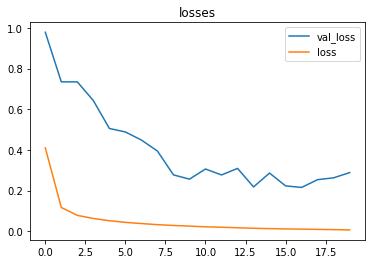

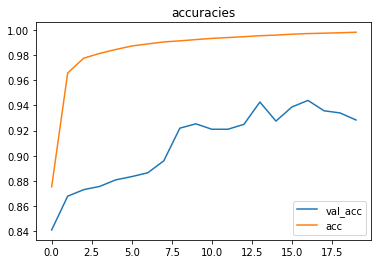

In [9]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [10]:
with tf.device('CPU:0'):
    baseline_test_preds = tf.argmax(baseline(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    baseline_fscore = sklearn.metrics.f1_score(test_labels, baseline_test_preds, average = 'macro')
    print(f'gmean: {baseline_gmean} \nfscore: {baseline_fscore}')

gmean: 0.9070971194181239 
fscore: 0.9200872116331776


## train and evaluate model on randomly oversampled data

In [11]:
print(f'before ros {hf.Imbalance.get_set_distribution(imb_train_labels)}')


imb_train_shape = imb_train_images.shape
#imb_validation_shape = imb_validation_images.shape
imb_train_images = imb_train_images.reshape(imb_train_shape[0], 
                                            imb_train_shape[1] * imb_train_shape[2])
#imb_validation_images = imb_validation_images.reshape(imb_validation_shape[0], 
#                                                      imb_validation_shape[1] * imb_validation_shape[2])



ros = imblearn.over_sampling.RandomOverSampler(random_state = 0)
(ros_train_images, ros_train_labels) = ros.fit_resample(imb_train_images, imb_train_labels)
#ros = imblearn.over_sampling.RandomOverSampler(random_state = 0)
#(ros_validation_images, ros_validation_labels) = ros.fit_resample(imb_validation_images, 
#                                                                  imb_validation_labels)



ros_train_images = ros_train_images.reshape(ros_train_images.shape[0], 
                                            imb_train_shape[1], 
                                            imb_train_shape[2])
#ros_validation_images = ros_validation_images.reshape(ros_validation_images.shape[0], 
#                                                      imb_validation_shape[1], 
#                                                      imb_validation_shape[2])
        
permutation = np.random.permutation(np.arange(ros_train_images.shape[0]))
print(permutation)
ros_train_images = ros_train_images[permutation]
ros_train_labels = ros_train_labels[permutation]

print(f'after ros {hf.Imbalance.get_set_distribution(ros_train_labels)}')



ros_train_images_expanded = np.expand_dims(ros_train_images, axis = 3)
#ros_validation_images_expanded = np.expand_dims(ros_validation_images, axis = 3)
with tf.device('CPU:0'):
    ros_train_images_tf = tf.cast(ros_train_images_expanded, dtype = tf.float32) / 255.0
    #ros_validation_images_tf = tf.cast(ros_validation_images_expanded, dtype = tf.float32) / 255.0

before ros {0: 5150, 1: 5, 2: 5150, 3: 5150, 4: 5150, 5: 5150, 6: 5150, 7: 5150, 8: 5150, 9: 5150}
[11152  2514 40013 ... 35147 13611 24413]
after ros {0: 5150, 1: 5150, 2: 5150, 3: 5150, 4: 5150, 5: 5150, 6: 5150, 7: 5150, 8: 5150, 9: 5150}


In [12]:
for i in range(ros_train_images.shape[0]):
    if ros_train_labels[i] == 2:
        print(i)

20
28
31
48
50
53
57
62
73
91
93
108
122
123
128
139
140
143
145
170
180
186
191
193
203
208
224
226
228
254
272
293
298
309
317
320
345
354
357
358
370
371
375
377
378
379
423
445
451
458
465
467
468
498
507
512
555
558
561
562
565
566
567
571
573
581
592
597
628
632
640
651
652
675
678
690
692
698
714
733
769
785
790
792
793
798
823
840
844
846
865
880
881
912
913
943
947
956
963
965
978
981
988
993
998
1005
1021
1030
1042
1045
1050
1059
1061
1078
1097
1102
1145
1146
1147
1149
1157
1175
1218
1228
1241
1252
1259
1278
1281
1290
1291
1294
1355
1372
1375
1377
1390
1391
1394
1395
1397
1398
1441
1454
1458
1476
1477
1493
1562
1582
1583
1584
1585
1601
1627
1632
1633
1635
1651
1654
1671
1675
1693
1701
1708
1717
1754
1757
1759
1760
1764
1778
1788
1791
1793
1844
1860
1863
1882
1888
1890
1893
1900
1907
1928
1932
1935
1955
1964
1972
2004
2008
2017
2021
2060
2067
2078
2083
2103
2104
2136
2137
2153
2165
2177
2195
2214
2215
2225
2236
2245
2249
2262
2269
2280
2291
2301
2302
2304
2308
2315
2317
2333
2

25194
25198
25214
25224
25225
25238
25241
25258
25261
25265
25279
25280
25282
25286
25313
25327
25332
25347
25350
25356
25359
25377
25384
25393
25405
25413
25437
25447
25455
25456
25461
25462
25463
25465
25467
25468
25482
25487
25488
25498
25501
25509
25520
25523
25524
25532
25545
25549
25554
25585
25586
25636
25639
25652
25657
25665
25672
25699
25702
25721
25727
25731
25741
25748
25750
25752
25757
25767
25775
25789
25798
25801
25822
25828
25859
25862
25873
25887
25910
25912
25940
25973
25974
25998
26009
26019
26025
26030
26033
26038
26044
26061
26068
26072
26086
26089
26090
26092
26096
26119
26131
26146
26165
26168
26172
26182
26194
26230
26246
26250
26251
26266
26269
26274
26287
26307
26312
26313
26319
26323
26355
26360
26362
26367
26386
26391
26394
26400
26405
26414
26426
26443
26461
26476
26490
26497
26507
26512
26515
26524
26526
26528
26530
26531
26535
26536
26543
26551
26583
26591
26601
26624
26627
26628
26642
26674
26678
26692
26694
26717
26722
26724
26729
26741
26758
26760
2676

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [14]:
model_ros = tf.keras.models.Sequential()
history = model_run(model_ros, 20, ros_train_images_tf, ros_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
                    optimizer, loss, metrics, callbacks)

Train on 51500 samples, validate on 2318 samples
Epoch 1/20
51500/51500 [==============================] - 7s 129us/sample - loss: 0.3672 - acc: 0.8984 - val_loss: 0.2210 - val_acc: 0.9418
Epoch 2/20
51500/51500 [==============================] - 6s 117us/sample - loss: 0.1006 - acc: 0.9703 - val_loss: 0.1553 - val_acc: 0.9620
Epoch 3/20
51500/51500 [==============================] - 6s 117us/sample - loss: 0.0694 - acc: 0.9791 - val_loss: 0.1814 - val_acc: 0.9573
Epoch 4/20
51500/51500 [==============================] - 6s 117us/sample - loss: 0.0549 - acc: 0.9832 - val_loss: 0.1635 - val_acc: 0.9638
Epoch 5/20
51500/51500 [==============================] - 6s 117us/sample - loss: 0.0441 - acc: 0.9867 - val_loss: 0.1707 - val_acc: 0.9607
Epoch 6/20
51500/51500 [==============================] - 6s 117us/sample - loss: 0.0376 - acc: 0.9887 - val_loss: 0.1523 - val_acc: 0.9659
Epoch 7/20
51500/51500 [==============================] - 6s 116us/sample - loss: 0.0317 - acc: 0.9902 - val_lo

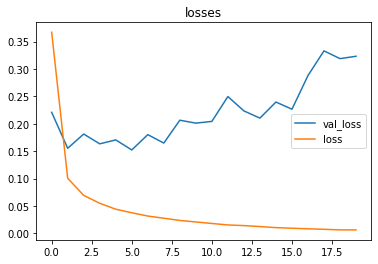

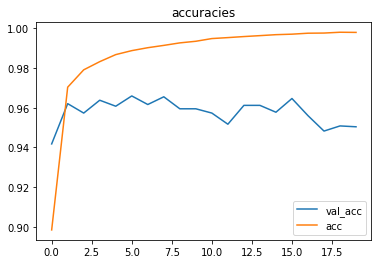

In [15]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [16]:
with tf.device('CPU:0'):
    model_ros_test_preds = tf.argmax(model_ros(test_images_tf), axis=-1)
    model_ros_gmean = imblearn.metrics.geometric_mean_score(test_labels, model_ros_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    model_ros_fscore = sklearn.metrics.f1_score(test_labels, model_ros_test_preds, average = 'macro')
    print(f'gmean: {model_ros_gmean} \nfscore: {model_ros_fscore}')

gmean: 0.9452076296536094 
fscore: 0.9489245494775614
